<a href="https://colab.research.google.com/github/jear2412/MCMC/blob/master/PT-HMC-SIRblackplague.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import scipy
import scipy.integrate
from scipy.integrate import odeint


sns.set()


In [2]:
def Analysis(x):
    var=np.var(x,0)

    ess=np.zeros( x.shape[1])
    for i in range( x.shape[1] ):
      ess[i]=tfp.mcmc.effective_sample_size(  x[:,i] , filter_beyond_positive_pairs=True)
    
    mess=np.min(ess)
    N=x.shape[0]
    summary= {
        "TotalObs": N,
        "Variance": var,
        "mVar": var/ess,
        "ess": ess,
        "mess":mess, #min ess
        "IAT": N/ess, 
        }
    return summary

In [5]:
#Databases

SIRdE=pd.read_csv('SIR2dE.csv')
SIRdex=pd.read_csv('SIR2dex.csv')
#SIRdms=pd.read_csv('SIR2dms.csv')
SIRobs=pd.read_csv('SIR2obs.csv')


In [92]:
pd.DataFrame.describe(SIRobs)


,Unnamed: 0,alpha,beta,I0,E,lp__
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7500.500000,0.047606,0.000677,7.683050,467.316720,-478.956542
std,4330.271354,0.043332,0.000034,2.609866,103.799565,105.996601
min,1.000000,0.012705,0.000546,3.035879,333.322769,-571.565008
25%,3750.750000,0.013725,0.000655,4.569378,334.948746,-561.864196
50%,7500.500000,0.014054,0.000679,9.508198,547.406605,-560.856627
75%,11250.250000,0.100301,0.000700,9.838904,548.576054,-343.787674
max,15000.000000,0.121815,0.000850,9.999786,560.826903,-342.133216


In [93]:
pd.DataFrame.median(SIRobs)


Unnamed: 0    7500.500000
alpha            0.014054
beta             0.000679
I0               9.508198
E              547.406605
lp__          -560.856627
dtype: float64

In [94]:
pd.DataFrame.quantile(SIRobs, (0.025, 0.975))

,Unnamed: 0,alpha,beta,I0,E,lp__
0.025,375.975,0.013296,0.000604,3.650175,333.530911,-564.824659
0.975,14625.025,0.111750,0.000741,9.985954,551.448607,-342.340922


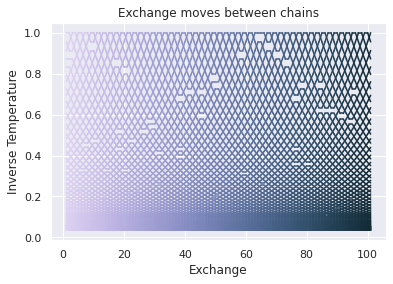

In [9]:
ax=sns.lineplot(x="x", y="y", hue="g",data=SIRdex, legend=False,  palette="ch:2.5,.25") 
ax.set(xlabel="Exchange", ylabel = "Inverse Temperature")
ax.set_title('Exchange moves between chains')
plt.savefig('PTSIR1.png', dpi=500)

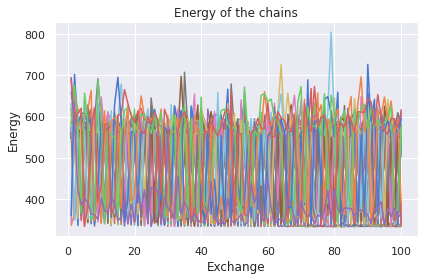

In [10]:
ax=sns.lineplot(x="Exchange", y="E", hue="Replica", data=SIRdE, legend=False,  palette="muted")
ax.set(xlabel="Exchange", ylabel = "Energy")
ax.set_title('Energy of the chains')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.savefig('PTSIR2.png', dpi=450)

In [32]:
alpha= SIRobs['alpha']
beta= SIRobs['beta']
I0= SIRobs['I0']

alpha=pd.DataFrame.to_numpy(alpha)
beta=pd.DataFrame.to_numpy(beta)
I0=pd.DataFrame.to_numpy(I0)

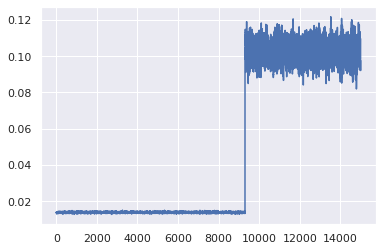

In [12]:
plt.plot(alpha)

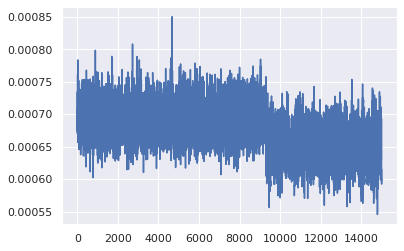

In [13]:
plt.plot(beta)

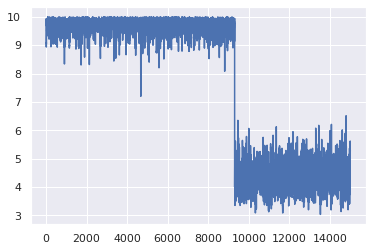

In [14]:
plt.plot(I0)

In [17]:
rhmc={'alpha':alpha, 'beta':beta, 'I0':I0   }
rhmc=pd.DataFrame(rhmc)




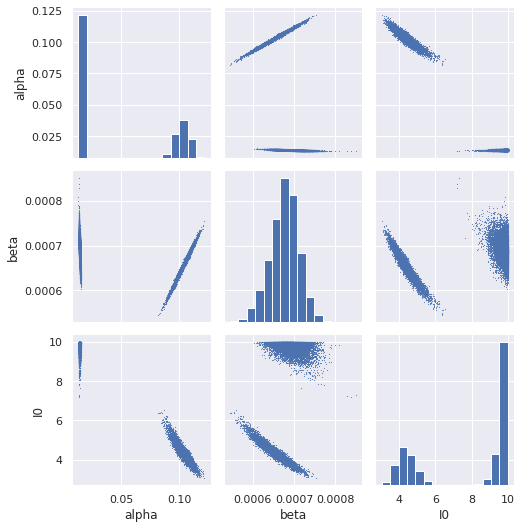

In [84]:
sns.pairplot(rhmc, markers='.', plot_kws=dict(s=0.5, edgecolor="b"),diag_kws=dict(bins=15) )
plt.tight_layout()
plt.savefig('PTHMCpairplot.png', dpi=500)

In [33]:

''' Second black plague outbreak in Eyam, UK 
    June 19, 1666 to Nov 1, 1666 (Massel et al 2004)
    114 days
    The village had been quarantined so the population
    is fixed to N=261. 
    
    States: 
        S(t): susceptible
        I(t): infected
        R(t): removed
        N=S(t)+I(t)+R(t)
    obs: once you get the plague you never recover, you die 
    
    '''
    
N=261 #Total population   

def SIR( X, t,  alpha, beta, I0  ):
    dSdt= -beta* X[0] * X[1]
    dIdt= beta*X[0] * X[1]- alpha*X[1]
    dRdt= alpha*X[1]
    return np.array( [   dSdt, dIdt, dRdt   ]   )
    

data = pd.read_csv("Eyam_time_SIR.csv") 
data.index
y=np.append(0, pd.Series.to_numpy(data.iloc[:, 3])) #cumulative deaths 
x=pd.Series.to_numpy(data.iloc[ 111:114 , 2 ])
n=len(y)        
ts=np.arange(0,len(y),1 )






In [34]:

def predobs( alpha, beta, I0s, tup=136  ,sample_size=150 ):
    L=len(alpha)
    obs=np.zeros([ sample_size  , tup]) 
    
    SSts=np.zeros([ sample_size  , tup]) 
    IIts=np.zeros([ sample_size  , tup]) 
    RRts=np.zeros([ sample_size  , tup]) 
    
    ts=np.arange(0,tup, 1)
    
    #sample of size sample_size of betas and I0s. 
    #which observations to take into account for the predictive
    indexes=np.random.choice(a = np.arange( 0, L )   , size = sample_size, replace = False)
    
    salphas=alpha[indexes]
    sI0s= I0s[indexes]
    sbetas= beta[indexes]
    for i in range(sample_size ):
        X0=np.array( [N-I0s[i], I0s[i], 0] )
        Xt=scipy.integrate.odeint( SIR, X0, ts, args=(salphas[i],sbetas[i],sI0s[i],) ) 
        It=Xt[:,1]
        It[It<0]=0
        Rt=Xt[:,2]
        Rt[Rt>261]=261
        
        SSts[i]=Xt[ :,0]
        IIts[i]=Xt[ :,1]
        RRts[i]=Xt[ :,2]
        obs[i]=scipy.stats.binom.rvs( n=N, p= Rt/N )
        
    return SSts, IIts, RRts,  obs
        
        



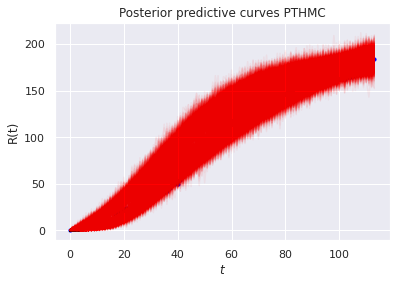

In [88]:
#### Predictive distribution

SSts, IIts, RRts,  obspred=predobs(alpha, beta, I0 , tup=114, sample_size=2500)

indexes=np.random.choice(a = np.arange( 0,  obspred.shape[0] ), size =2500, replace = False)
obs_samples=obspred[indexes]

SSts_samples=SSts[indexes]
IIts_samples=IIts[indexes]

for i in range( len(obs_samples )  ):
    plt.plot(obs_samples[i], color='red' , alpha=0.05 )

plt.scatter(ts,y, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'Posterior predictive curves PTHMC' )
plt.savefig( 'PTHMCRtBlackPlague.pdf', dpi=500  )
plt.show()


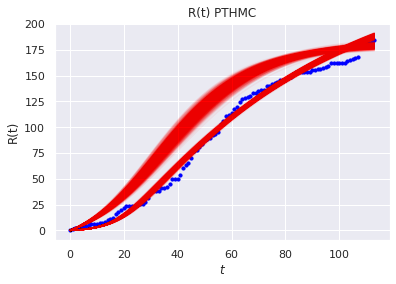

In [89]:
for i in range( len(obs_samples )  ):
    plt.plot(RRts[i], color='red' , alpha=0.05 )
plt.scatter(ts,y, s=10, color='blue', zorder=1)
plt.xlabel( r'$t$' )
plt.ylabel( r'R(t)' )
plt.title( 'R(t) PTHMC' )
plt.savefig( 'PTHMCRt.pdf', dpi=500  )
plt.show()




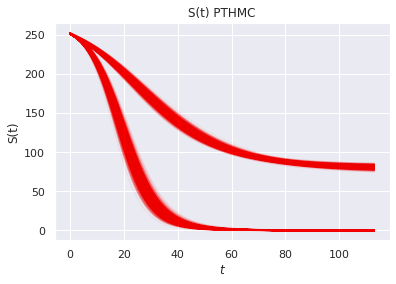

In [90]:
for i in range( len(obs_samples )  ):
    plt.plot(SSts[i], color='red' , alpha=0.05 )
plt.xlabel( r'$t$' )
plt.ylabel( r'S(t)' )
plt.title( 'S(t) PTHMC' )
plt.savefig( 'PTHMCSt.pdf', dpi=500  )
plt.show()


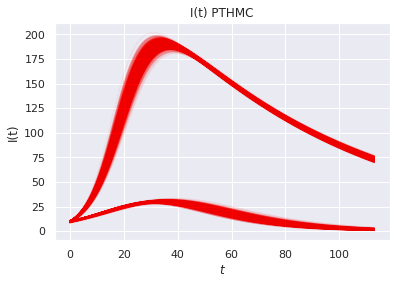

In [91]:
for i in range( len(obs_samples )  ):
    plt.plot(IIts[i], color='red' , alpha=0.05 )
plt.xlabel( r'$t$' )
plt.ylabel( r'I(t)' )
plt.title( 'I(t) PTHMC' )
plt.savefig( 'PTHMCIt.pdf', dpi=500  )
plt.show()

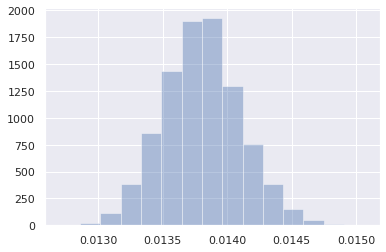

In [79]:
sns.distplot(alpha[alpha<0.06], kde=False, bins=15)

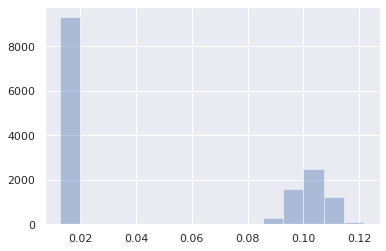

In [80]:
sns.distplot(alpha, kde=False, bins=15)

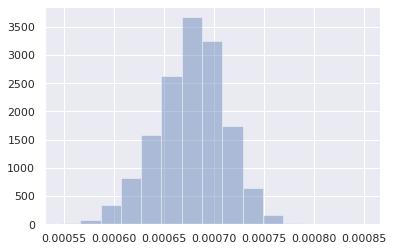

In [75]:
sns.distplot(beta, kde=False, bins=15)

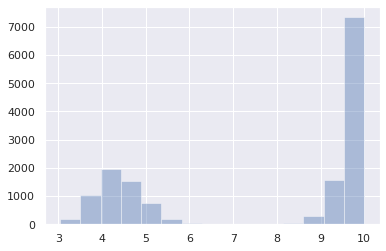

In [76]:
sns.distplot(I0, kde=False, bins=15)

In [1]:
plt.plot(alpha, I0)

NameError: ignored